In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

Visual parameters

In [2]:
palette = sns.color_palette('bright')
kde_params = dict(linewidth = 3)

# Common data features

In [3]:
data = pd.read_csv('data/titanic_classification.csv')
data = data[['Survived'] + [item for item in data.columns if item != 'Survived']]
data.head()

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.columns

Index(['Survived', 'PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

It is obviously that such columns as "PassengerId" and "Ticket" have no impact on surviving.

In [5]:
data = data.drop(columns=['PassengerId', 'Ticket'])
data.shape

(891, 10)

In [6]:
data.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [7]:
data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [8]:
data.duplicated().sum()

0

The data has 2 extra columns (Id and Ticket), categorical (numbers and text) and continuous data, no duplicates and 177 NaN values in column "Age", 687 NaNs in column "Cabin", 2 NaNs in "Embarked".

# Exploration Data Analysis

## Distribution of target

In [9]:
data['Survived'].mean()

0.3838383838383838

We can notice that we have more dead people than alive, but it doesn't matter, distribution is near to 50-50.

## Processing columns with NaNs

In [10]:
data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### Cabin feature

As we see there is a lot of nans in Age, Cabin, and only two in Embarked. More than that number of Nans in "Cabin" is nearly two thirds of all data, therefore we can't use this columns for learning our model.

In [11]:
data = data.drop(columns=['Cabin'])

### Age feature
Let's check what is going on with Age, should we brush aside this column or not?

In [12]:
data_no_nan = data[~data['Age'].isna()]

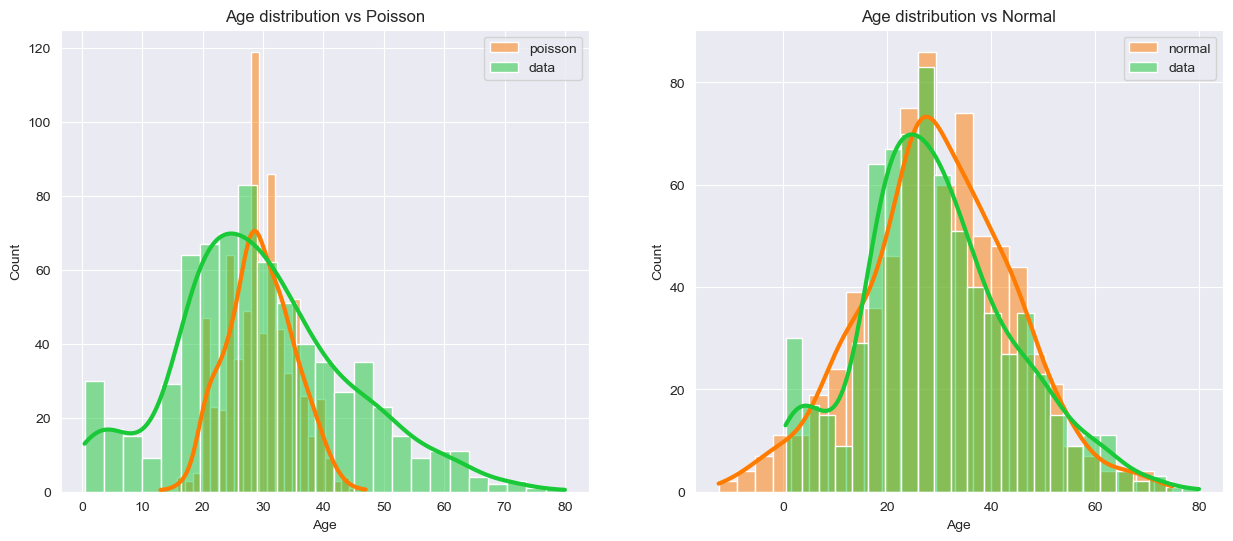

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))
axes[0].title.set_text('Age distribution vs Poisson')
axes[1].title.set_text('Age distribution vs Normal')
sns.histplot(np.random.normal(data_no_nan['Age'].mean(), math.sqrt(data_no_nan['Age'].var()), len(data_no_nan)), ax=axes[1], kde=True, color=palette[1], bins=25, label='normal', line_kws=kde_params)
sns.histplot(np.random.poisson(data_no_nan['Age'].mean(), len(data_no_nan)), ax=axes[0], kde=True,
             color=palette[1], bins=25, label='poisson', line_kws=kde_params)
sns.histplot(data_no_nan['Age'],  kde=True, ax=axes[0], bins=25, label='data', color=palette[2], line_kws=kde_params)
sns.histplot(data_no_nan['Age'],  kde=True, ax=axes[1], bins=25, label='data', color=palette[2], line_kws=kde_params)
axes[0].legend()
axes[1].legend()
plt.show()

As we see distribution of Age is pretty similar to Normal one but right skewed. We could add "Age" values from normal distribution, but it will change parameters of real distribution, so it is better to replace NaN values with median

In [14]:
data.loc[data['Age'].isnull(), 'Age'] = data_no_nan['Age'].median()

### Embarked feature

There are 3 places of Embarkation: Cherbourg, Queenstown, Southampton

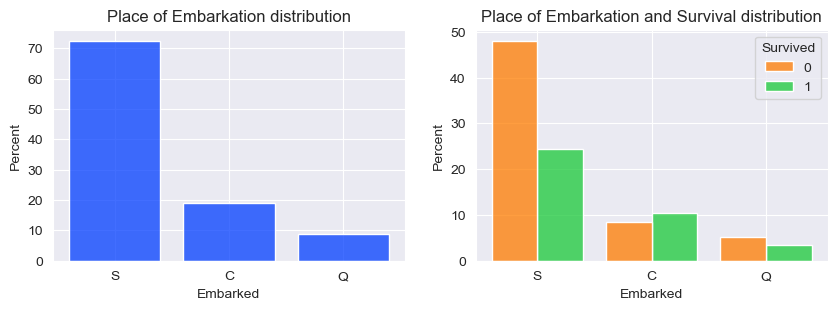

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
axes[0].title.set_text('Place of Embarkation distribution')
axes[1].title.set_text('Place of Embarkation and Survival distribution')
sns.histplot(data=data, x='Embarked', color=palette[0],  stat='percent', ax=axes[0], shrink=0.8)
sns.histplot(data=data, x='Embarked', hue='Survived', palette=palette[1:3], multiple='dodge', stat='percent', ax=axes[1], shrink=0.8)
plt.show()

More than 70% of passengers have embarked in Southampton, so 2 NaNs can be marked as "S" without any distortion of data distribution

In [16]:
data.loc[data['Embarked'].isna(), 'Embarked'] = 'S'

Let's encode this categorical feature to number

In [17]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(data[['Embarked']])
data['Embarked'] = enc.transform(data[['Embarked']])
enc.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [18]:
data['Embarked'] = data['Embarked'].astype(int)

## Processing other columns without NaNs

In [19]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,2


### Pclass
Not convenient to start from Pclass = 1 to 3 whereas 'Embarked' changing from 0 to 2

In [20]:
data['Pclass'] = data['Pclass'] - 1
data['Pclass'] = data['Pclass'].astype(int)

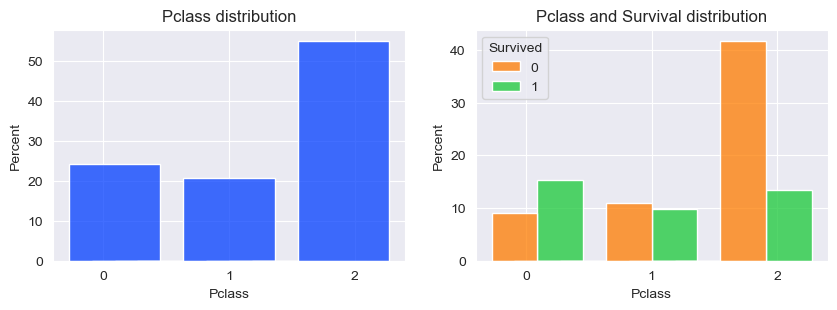

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
axes[0].title.set_text('Pclass distribution')
axes[1].title.set_text('Pclass and Survival distribution')
axes[0].set_xticks(np.arange(0, 3, 1))
axes[1].set_xticks(np.arange(0, 3, 1))
sns.histplot(data, x='Pclass', stat='percent', multiple='dodge', ax=axes[0], color=palette[0], shrink=4)
sns.histplot(data, x='Pclass', hue='Survived', stat='percent', multiple='dodge', ax=axes[1], palette=palette[1:3], shrink=4)
plt.show()

More than a half of passengers have "Pclass" = 2, and only fourth of them survived whereas passengers with "Pclass" = 0 or 1 have more chances to survive

### Name (name_cat)

Columns name has some interesting features: Mr, Mrs... let's explore this phenomenon.

In [22]:
# Functions to parse features from Name

# Find all indices where s[id] == sym
def find_all(sym, s):
    return [i for i, value in enumerate(s) if value == sym]

# Function to extract from "texttext Mrs. texttexttext" word "Mrs".
def parse_name(x):
    if '.' in x:
        end = x.index('.')
        indices = find_all(' ', x)
        start = [i for i in indices if i < end][-1]
        cat = x[start+1:end]
    else:
        cat = 'other'
    return cat

In [23]:
data['name_cat'] = data['Name'].apply(parse_name)
data['name_cat'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

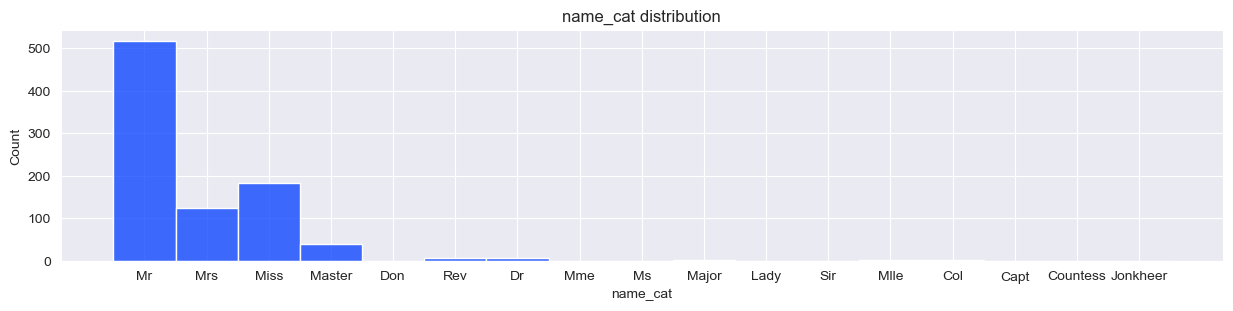

In [24]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.title.set_text('name_cat distribution')
sns.histplot(data, x='name_cat', ax=ax, color=palette[0])
plt.show()

So many unique categories, but most of them are useless.

In [25]:
most_freq = ['Mr', 'Mrs', 'Miss', 'Master']
data['name_cat'] = data['name_cat'].apply(lambda x: x if x in most_freq else 'other')
data['name_cat'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'other'], dtype=object)

What with connection of survived and name categories?


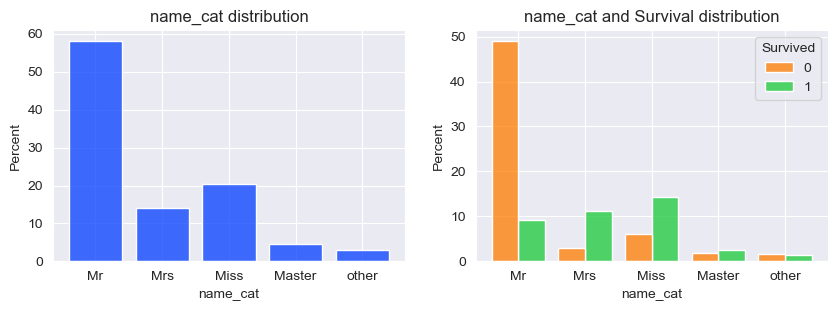

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
axes[0].title.set_text('name_cat distribution')
axes[1].title.set_text('name_cat and Survival distribution')
sns.histplot(data, x='name_cat', ax=axes[0], stat='percent', color=palette[0], shrink=0.8)
sns.histplot(data, x='name_cat', ax=axes[1], hue='Survived', multiple='dodge', stat='percent', palette=palette[1:3], shrink=0.8)
plt.show()

Most popular category is "Mr" and "Mr" definitely has fewer chances to survive. We will return to this distribution when we talk about "Sex".

In [27]:
enc = OrdinalEncoder()
enc.fit(data[['name_cat']])
data['name_cat'] = enc.transform(data[['name_cat']])
enc.categories_

[array(['Master', 'Miss', 'Mr', 'Mrs', 'other'], dtype=object)]

Now column "Name" is useless

In [28]:
data.drop(columns=['Name'], inplace=True)
data['name_cat'] = data['name_cat'].astype(int)

### Sex

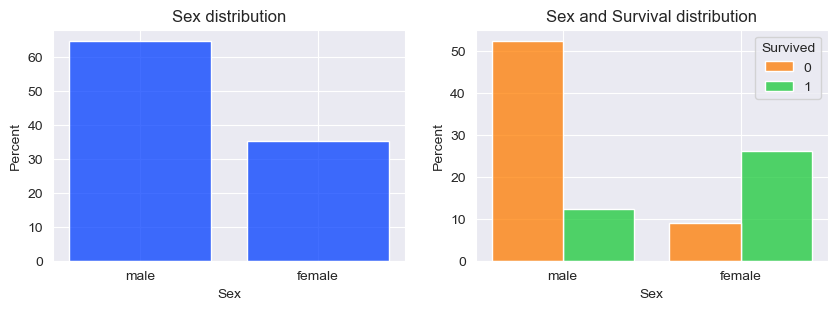

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
axes[0].title.set_text('Sex distribution')
axes[1].title.set_text('Sex and Survival distribution')
sns.histplot(data, x='Sex', ax=axes[0], stat='percent', color=palette[0], shrink=0.8)
sns.histplot(data, x='Sex', hue='Survived', ax=axes[1], multiple='dodge', stat='percent', palette=palette[1:3], shrink=0.8)
plt.show()

We should keep in mind that men had more chances to survive (2 times more), but we remember that we already have very similar feature called "name_cat". Comparing name_cat and Sex we can understand that name_cat is more representative than Sex because it shows us not just male-female distribution but Mr-Miss-Mrs-Master-Other. As we know we use "Miss" to talk about an unmarried woman whereas "Mrs" to talk about married one. After looking at the previous graph we realize that "Mrs" has more chances to survive than "Miss", so it maybe will help us in predicting. This approach has disadvantage - we have "other" and "master" instead of "female" and "male", but number of these cases is so small comparing to all data.
To sum up, it is obviously that "Sex" should be replaced with "name_cat".

In [30]:
data.drop(columns=['Sex'], inplace=True)

### Sibsp
number of siblings/spouses aboard the Titanic

In [31]:
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,name_cat
0,0,2,22.0,1,0,7.2500,2,2
1,1,0,38.0,1,0,71.2833,0,3
2,1,2,26.0,0,0,7.9250,2,1
3,1,0,35.0,1,0,53.1000,2,3
4,0,2,35.0,0,0,8.0500,2,2


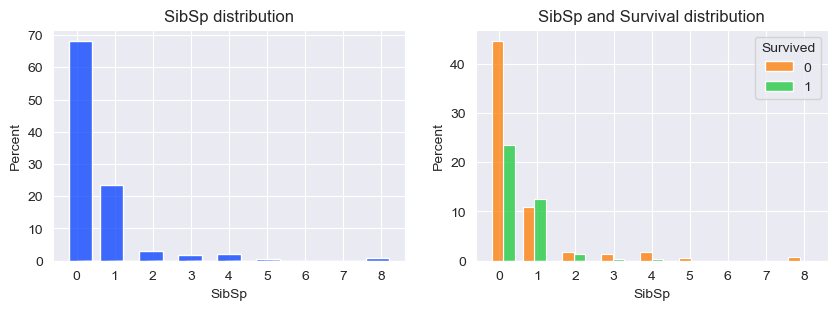

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
axes[0].title.set_text('SibSp distribution')
axes[1].title.set_text('SibSp and Survival distribution')
axes[0].set_xticks(np.arange(0, 10, 1))
axes[1].set_xticks(np.arange(0, 10, 1))
sns.histplot(data, x='SibSp', ax=axes[0], stat='percent', color=palette[0],  shrink=3)
sns.histplot(data, x='SibSp', hue='Survived', ax=axes[1], multiple='dodge', stat='percent', palette=palette[1:3], shrink=3)
plt.show()

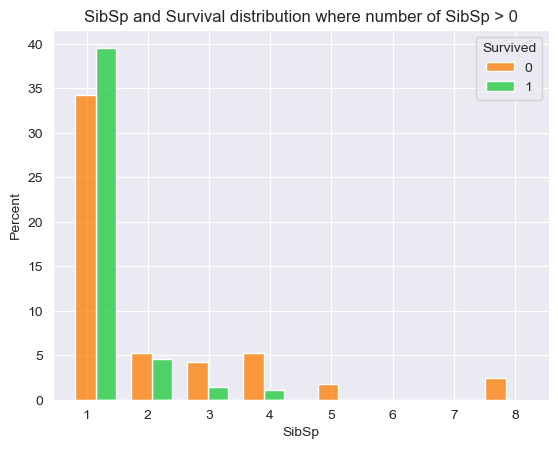

In [33]:
fig, ax = plt.subplots()
ax.title.set_text('SibSp and Survival distribution where number of SibSp > 0')
sns.histplot(data[data['SibSp']>0], x='SibSp',hue='Survived', multiple='dodge', stat='percent',palette=palette[1:3], shrink=2.2)
plt.show()

It is easy to create 4 categories:
- 0 - no siblings/spouses. Here almost 2 times more people not survived.
- 1 - 1 or 2. Here number of dead/alive is approximately equal
- 2 3 or 4. There are few members of this category and more not survived people among them
- 3 more than 4. There are no survived at all

In [34]:
bins = [-0.1,0.5, 2, 4, 8]
labels = [0, 1, 2, 3]
data['SibSp'] = pd.cut(data['SibSp'], bins=bins, labels=labels).to_numpy()
data['SibSp'] = data['SibSp'].astype(int)

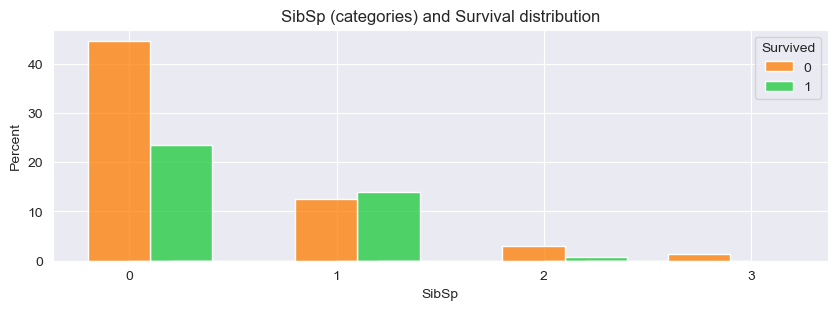

In [35]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data, x='SibSp', hue='Survived', multiple='dodge', stat='percent', palette=palette[1:3], shrink=3)
ax.set_xticks(np.arange(0, 4, 1))
ax.title.set_text('SibSp (categories) and Survival distribution')
plt.show()

### parch
number of parents/children

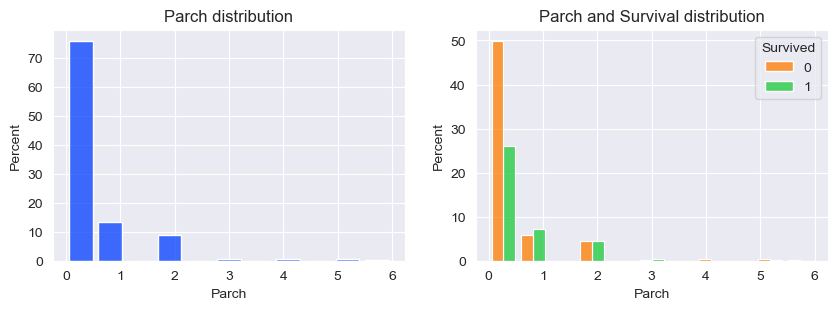

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
axes[0].set_xticks(np.arange(0, 10, 1))
axes[1].set_xticks(np.arange(0, 10, 1))
axes[0].title.set_text('Parch distribution')
axes[1].title.set_text('Parch and Survival distribution')
sns.histplot(data, x='Parch', ax=axes[0], stat='percent', color=palette[0], shrink=0.8)
sns.histplot(data, x='Parch', hue='Survived', ax=axes[1], multiple='dodge', stat='percent', palette=palette[1:3], shrink=0.8)
plt.show()

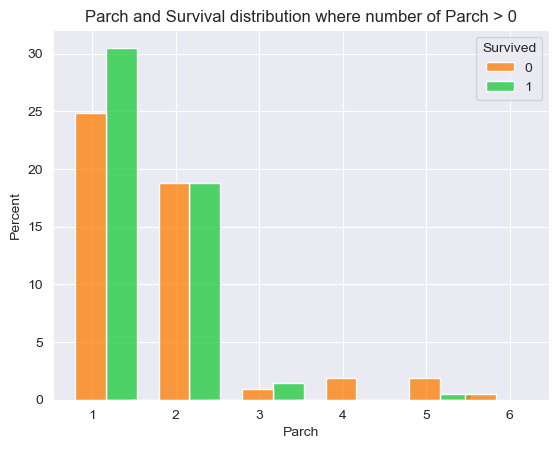

In [37]:
fig, ax = plt.subplots()
ax.title.set_text('Parch and Survival distribution where number of Parch > 0')
sns.histplot(data[data['Parch']>0], x='Parch',hue='Survived', multiple='dodge', stat='percent',palette=palette[1:3], shrink=2.2)
plt.show()

The same situation was with SibSp. We can create 3 categories:
- 0 - 0 Parch (more likely to die)
- 1 - 1 or 2 Parents/children (have 50-50 chances to survive)
- 2 - more than 2 Parents or children (like category "other")

In [38]:
bins = [-0.1,0.5, 2, 6]
labels = [0, 1, 2]
data['Parch'] = pd.cut(data['Parch'], bins=bins, labels=labels).to_numpy()
data['Parch'] = data['Parch'].astype(int)

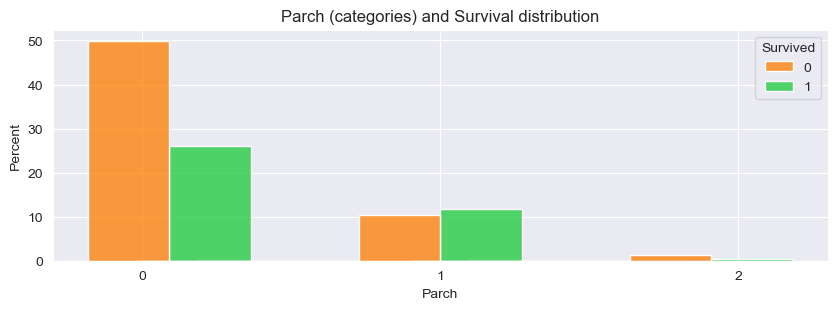

In [39]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data, x='Parch', hue='Survived', multiple='dodge', stat='percent', palette=palette[1:3], shrink=3)
ax.set_xticks(np.arange(0, 3, 1))
ax.title.set_text('Parch (categories) and Survival distribution')
plt.show()

### Fare

90.0 % of data is people with Fare < 100


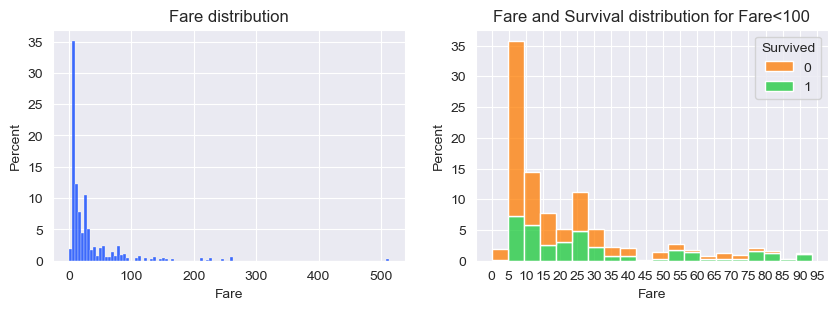

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
axes[0].title.set_text('Fare distribution')
axes[1].title.set_text('Fare and Survival distribution for Fare<100')
axes[1].set(xticks=np.arange(0,100, 5))
sns.histplot(data, x='Fare', ax=axes[0], stat='percent', color=palette[0])
sns.histplot(data[data['Fare']<100], x='Fare', ax=axes[1], stat='percent', hue='Survived', palette=palette[1:3], multiple='stack', bins=20)
print(round(data[data['Fare']<100]['Fare'].count()/len(data), 1)*100, '% of data is people with Fare < 100')
plt.show()

We can see that passengers with fare 5-10 have fewer chances to survive. In general, people with low fare are more likely to die comparing with people with high fare.

## Correlations in data

In [41]:
data.corr()['Survived']

Survived    1.000000
Pclass     -0.338481
Age        -0.064910
SibSp       0.029846
Parch       0.124245
Fare        0.257307
Embarked   -0.167675
name_cat   -0.052471
Name: Survived, dtype: float64

Negative correlation between "Pclass" and "Survived" (there are a lot of dead passenger in 2nd class).
Positive correlation between "Fare" and "Survived" (the higher fare is -> higher survival rate is)

<AxesSubplot:>

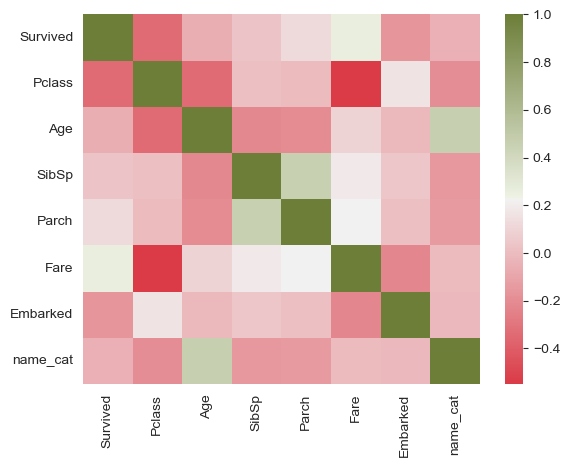

In [42]:
sns.heatmap(data.corr(), cmap=sns.diverging_palette(10, 100, as_cmap=True))

# Data splitting

In [43]:
from sklearn.model_selection import train_test_split

X = data[[item for item in data.columns if item != 'Survived']]
y = data['Survived'].to_numpy().reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((801, 7), (90, 7))

In [44]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,name_cat
165,2,9.0,0,1,20.5250,2,0
541,2,9.0,2,1,31.2750,2,1
625,0,61.0,0,0,32.3208,2,2
388,2,28.0,0,0,7.7292,1,2
76,2,28.0,0,0,7.8958,2,2


# Models

In [45]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

In [46]:
# list for results of models needed to create comparison plot.
model_results = []

# Function for adding results of model to list and printing the results
def report(name, y_true, y_pred, add=True):
    d = {
        'f1_score_0':  round(f1_score(y_true, y_pred, pos_label=0), 2),
        'f1_score_1':  round(f1_score(y_true, y_pred, pos_label=1), 2),
        'precision_0':  round(precision_score(y_true, y_pred, pos_label=0), 2),
        'precision_1':  round(precision_score(y_true, y_pred, pos_label=1), 2),
        'recall_0':  round(recall_score(y_true, y_pred, pos_label=0), 2),
        'recall_1':  round(recall_score(y_true, y_pred, pos_label=1), 2),
        'accuracy':  round(accuracy_score(y_true, y_pred), 2),
        'roc_auc': round(roc_auc_score(y_true, y_pred), 2)
    }
    if add:
        global model_results
        model_results.append({name: d})
    print(name)
    print('roc_auc_score: ', round(roc_auc_score(y_true, y_pred), 2))
    print(classification_report(y_true, y_pred))

## Model 0, Baseline

In [47]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)
report('DummyClassifier (most frequent)', y_test, clf.predict(X_test))

DummyClassifier (most frequent)
roc_auc_score:  0.5
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        54
           1       0.00      0.00      0.00        36

    accuracy                           0.60        90
   macro avg       0.30      0.50      0.37        90
weighted avg       0.36      0.60      0.45        90



C:\Users\shumi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shumi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shumi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shumi\anaconda3\lib\site-packages\sklearn\metrics\_classification.p

## Model 1, SVM

### sklearn.svm.SVC

Let's build a SVM model! Sklearn let us change a lot of properties for this model, so we can use Pipeline in order to find best one.
I decided to use grid search and take 2 decision function shapes: "ovo" - one-versus-one and "ovr" - one-versus-rest, 4 regularization parameters: 1, 10, 25, 50 and 4 types of kernel: linear, polynomial, rbf, sigmoid.

In [48]:
from sklearn import svm
from sklearn.pipeline import  Pipeline
from sklearn.model_selection import GridSearchCV

*Be careful!! It will takes a lot of time* (~5min)

In [49]:
pipe = Pipeline([('SVM', svm.SVC())])
grid_params = dict(
    SVM__decision_function_shape=['ovo', 'ovr'],
    SVM__C = [1, 10, 25, 50],
    SVM__kernel = ['linear', 'polynomial', 'rbf', 'sigmoid'],
)
clf = GridSearchCV(pipe, param_grid=grid_params)
clf.fit(X_train, y_train)

C:\Users\shumi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shumi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shumi\anaconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\shumi\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "C:\Users\shumi\anaconda3\lib\si

GridSearchCV(estimator=Pipeline(steps=[('SVM', SVC())]),
             param_grid={'SVM__C': [1, 10, 25, 50],
                         'SVM__decision_function_shape': ['ovo', 'ovr'],
                         'SVM__kernel': ['linear', 'polynomial', 'rbf',
                                         'sigmoid']})

In [50]:
clf.best_estimator_

Pipeline(steps=[('SVM',
                 SVC(C=1, decision_function_shape='ovo', kernel='linear'))])

In [51]:
report('SVM', y_test, clf.predict(X_test))

SVM
roc_auc_score:  0.69
              precision    recall  f1-score   support

           0       0.74      0.80      0.77        54
           1       0.66      0.58      0.62        36

    accuracy                           0.71        90
   macro avg       0.70      0.69      0.69        90
weighted avg       0.71      0.71      0.71        90



The best estimator is SVM model with C=50, decision_function_shape 'ovo' and linear kernel.
- 0.81 accuracy
- 0.76 precision
- 0.78 recall
- 0.77 f1-score
SVM model gave us good results comparing with DummyClassifier. As we can see 78% of all survived and 76% of people predicted by model as survived were survived.

But what if we try to increase regularization parameter C?

In [52]:
svc = svm.SVC(C=75, decision_function_shape='ovo', kernel='linear')
svc.fit(X_train, y_train)
report('SVM', y_test, svc.predict(X_test), add=False)

SVM
roc_auc_score:  0.7
              precision    recall  f1-score   support

           0       0.75      0.81      0.78        54
           1       0.68      0.58      0.63        36

    accuracy                           0.72        90
   macro avg       0.71      0.70      0.70        90
weighted avg       0.72      0.72      0.72        90



Absolutely the same result, seems that we should stop on model with C=50.

### sklearn.svm.LinearSVC

We have tried SVC model and have seen that best kernel is linear, so we can try to use sklearn.svm.LinearSVC where additional parameters can be specified for Linear model

Let's think about our data. We have no outliers in data, so penalty will remain as 'l2', we will try to change loss and regularization parameter C.
We have already used GridSearchCV in searching params for our model, but now using of it - bad idea nad you will see why later

In [53]:
from sklearn.svm import LinearSVC
model = LinearSVC(loss='hinge', C=1e-4)
model.fit(X_train, y_train)
model.score(X_test, y_test)
report('', y_test, model.predict(X_test), add=False)


roc_auc_score:  0.62
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        54
           1       0.71      0.33      0.45        36

    accuracy                           0.68        90
   macro avg       0.69      0.62      0.61        90
weighted avg       0.69      0.68      0.64        90



We can wee not bad results, but what if we increase our C?

In [54]:
from sklearn.svm import LinearSVC
model = LinearSVC(loss='hinge', C=1e-3)
model.fit(X_train, y_train)
model.score(X_test, y_test)
report('', y_test, model.predict(X_test), add=False)


roc_auc_score:  0.62
              precision    recall  f1-score   support

           0       0.67      0.94      0.78        54
           1       0.79      0.31      0.44        36

    accuracy                           0.69        90
   macro avg       0.73      0.62      0.61        90
weighted avg       0.72      0.69      0.65        90



Now we have an error that means that C is so large and our algorithm can't find the answer -> we can't use this model because solution is not sustainable.

Decreasing is not a good way because quality decreases too.

In [55]:
from sklearn.svm import LinearSVC
model = LinearSVC(loss='hinge', C=1e-5)
model.fit(X_train, y_train)
model.score(X_test, y_test)
report('', y_test, model.predict(X_test), add=False)


roc_auc_score:  0.6
              precision    recall  f1-score   support

           0       0.65      0.94      0.77        54
           1       0.75      0.25      0.38        36

    accuracy                           0.67        90
   macro avg       0.70      0.60      0.57        90
weighted avg       0.69      0.67      0.61        90



Let's play around 1e-4. In order to save your time I will say the answer to you: the best model will be LinearSVC with C=4e-4 and 'squared_hinge'. Using 'hinge' leads us to a lot of errors and demand C about 1e-4 (and lower quality), but 'squared_hinge' let us use C=4e-4 and increase the quality

In [56]:
model = LinearSVC(loss='squared_hinge', C=4e-4)
model.fit(X_train, y_train)
model.score(X_test, y_test)
report('LinearSVC with squared_hinge', y_test, model.predict(X_test))

LinearSVC with squared_hinge
roc_auc_score:  0.64
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        54
           1       0.80      0.33      0.47        36

    accuracy                           0.70        90
   macro avg       0.74      0.64      0.63        90
weighted avg       0.73      0.70      0.66        90



Although SVC and LinearSVC both have linear kernel they have different results, SVC is much better than LinearSVC (0.81 acc vs 0.7). Why it is so?

Differences of SVC and LinearSVC algorithms:
- LinearSVC is based on liblinear estimator and **penalize the intercept** (it means that bias is regularized), whereas SVC is based on libsvm and don't.
- LinearSVC does ovr whereas SVC does ovo

## Model 2, KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipe = Pipeline(steps=[('KNN', KNeighborsClassifier())])

param_grid = dict(KNN__n_neighbors = [5, 10, 20, 30, 40],
                  KNN__weights=['uniform', 'distance'],
                  KNN__algorithm=['ball_tree', 'kd_tree', 'brute'])

grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='accuracy')
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'KNN__algorithm': 'ball_tree',
 'KNN__n_neighbors': 20,
 'KNN__weights': 'distance'}

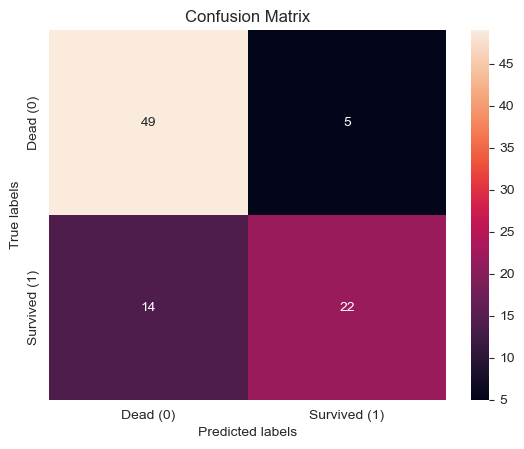

KNN
roc_auc_score:  0.76
              precision    recall  f1-score   support

           0       0.78      0.91      0.84        54
           1       0.81      0.61      0.70        36

    accuracy                           0.79        90
   macro avg       0.80      0.76      0.77        90
weighted avg       0.79      0.79      0.78        90



In [58]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, grid_search.predict(X_test), labels=grid_search.classes_), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Dead (0)', 'Survived (1)'])
ax.yaxis.set_ticklabels(['Dead (0)', 'Survived (1)'])
plt.show()
report('KNN', y_test, grid_search.predict(X_test))

Good imagination of our results:
- accuracy = (49+22)/(49+22+14+5) = 0.79
- precision (0) = 49/(49+14) = 0.78
 - precision (1) = 22/(22+5) = 0.81
- recall (0) = 49/(49+5) = 0.91
 - recall (1) = 22/(22+14) = 0.61

Here we can see that our model is good at searching dead people (we can find 91% of all dead people), but very bad in searching survived (we can find 61% of all survived). Our target was to find *SURVIVED* people, but this model can't be good at it

Also, we can play with params of algorithm 'ball_tree'.

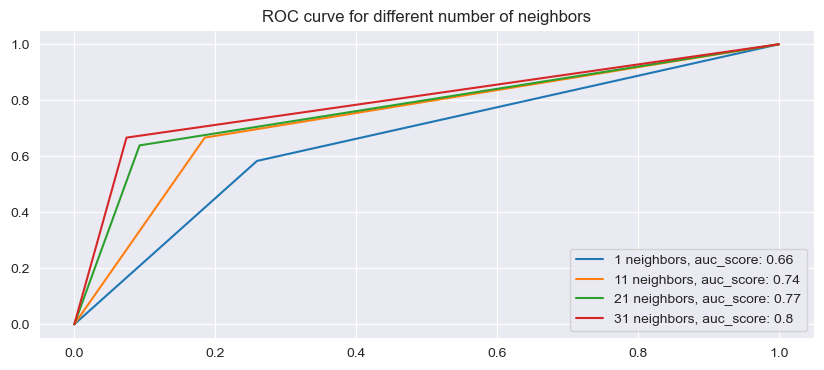

In [59]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, roc_auc_score
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(1, 41, 10):
    clf = KNeighborsClassifier(n_neighbors=i, algorithm='ball_tree', weights='distance')
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test).reshape(-1))
    roc_auc = roc_auc_score(y_test, clf.predict(X_test).reshape(-1))
    plt.plot(fpr, tpr, label=f'{i} neighbors, auc_score: {round(roc_auc, 2)}')
plt.legend(loc='lower right')
plt.title('ROC curve for different number of neighbors')
plt.show()

## Model 3, Decision tree Classifier

I will try to play with parameters of DecisionTree:
- criterion. This param establish how to calculate the impurity.
-- 'gini' := sum(Pi*(1-Pi))
-- 'entropy' or 'log_loss' are the same and calculate the impurity like sum(Pi*log(Pi))
- max_depth. Restriction of depth of our tree
- max_features. Number of features to consider when looking for the best split

In [60]:
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[('tree', tree.DecisionTreeClassifier())])

params = dict(tree__criterion = ['gini', 'entropy', 'log_loss'],
              tree__max_depth = [5, 10, 15, 20, 25],
              tree__max_features = ['sqrt',None,'log2'])
grid_search = GridSearchCV(pipe, param_grid=params, scoring='accuracy')

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'tree__criterion': 'entropy',
 'tree__max_depth': 5,
 'tree__max_features': None}

In [61]:
report('Random Decision Tree', y_test, grid_search.predict(X_test))

Random Decision Tree
roc_auc_score:  0.86
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        54
           1       0.83      0.83      0.83        36

    accuracy                           0.87        90
   macro avg       0.86      0.86      0.86        90
weighted avg       0.87      0.87      0.87        90



[Text(0.5, 0.875, 'x[6] <= 2.5\nlog_loss = 0.959\nsamples = 801\nvalue = [495, 306]'),
 Text(0.25, 0.625, 'x[6] <= 1.5\nlog_loss = 0.886\nsamples = 662\nvalue = [461, 201]'),
 Text(0.125, 0.375, 'x[0] <= 1.5\nlog_loss = 0.925\nsamples = 191\nvalue = [65, 126]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'x[4] <= 26.269\nlog_loss = 0.632\nsamples = 471\nvalue = [396, 75]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'x[0] <= 1.5\nlog_loss = 0.803\nsamples = 139\nvalue = [34, 105]'),
 Text(0.625, 0.375, 'x[6] <= 3.5\nlog_loss = 0.614\nsamples = 99\nvalue = [15, 84]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'x[1] <= 38.5\nlog_loss = 0.998\nsamples = 40\nvalue = [19, 21]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

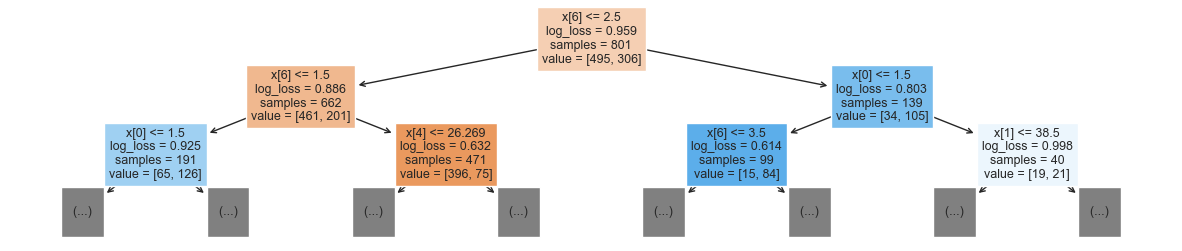

In [62]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=None)
clf.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(15, 3))
tree.plot_tree(clf, max_depth=2, ax=ax, filled=True)

This model is definitely better than KNN, because it has high f1_score_1 (0.83) and accuracy 0.87

## Model 4, RandomForest

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipe = Pipeline(steps=[('forest', RandomForestClassifier())])

params = dict(
    forest__criterion = ['gini', 'entropy', 'log_loss'],
    forest__max_depth = [3, 4, 5, 6, 7, 8],
    forest__max_features = ['sqrt',None,'log2']
)

grid_search = GridSearchCV(pipe, param_grid=params, scoring='accuracy')
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'forest__criterion': 'log_loss',
 'forest__max_depth': 8,
 'forest__max_features': None}

In [64]:
report('Random Forest', y_test, grid_search.predict(X_test))

Random Forest
roc_auc_score:  0.84
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        54
           1       0.79      0.83      0.81        36

    accuracy                           0.84        90
   macro avg       0.84      0.84      0.84        90
weighted avg       0.85      0.84      0.85        90



## Model 5, CatBoost

In [65]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train, y_train, test_size=0.1, random_state=123)
X_train_1.shape, y_valid_1.shape

((720, 7), (81,))

In [66]:
X_train_1.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,name_cat
544,0,50.00,1,0,106.4250,0,2
823,2,27.00,0,1,12.4750,2,3
803,2,0.42,0,1,8.5167,0,0
590,2,35.00,0,0,7.1250,2,2
142,2,24.00,1,0,15.8500,2,3


In [67]:
from catboost import CatBoostClassifier
cat_features = [0, 2, 3, 5, 6]
clf = CatBoostClassifier(
    iterations=20,
    learning_rate=0.4,
    loss_function='CrossEntropy',
    custom_loss=['Accuracy', 'F1'],
    max_depth=8,
)
fit_model = clf.fit(
    X_train_1,
    y_train_1,
    eval_set=(X_valid_1, y_valid_1),
    cat_features=cat_features,
    verbose=1)
fit_model.shrink(fit_model.get_best_iteration())
report('CatBoostClassifier', y_test, fit_model.predict(X_test))

0:	learn: 0.5926470	test: 0.5823229	best: 0.5823229 (0)	total: 169ms	remaining: 3.2s
1:	learn: 0.5183546	test: 0.5311277	best: 0.5311277 (1)	total: 198ms	remaining: 1.78s
2:	learn: 0.4755430	test: 0.4949215	best: 0.4949215 (2)	total: 211ms	remaining: 1.2s
3:	learn: 0.4461785	test: 0.4660550	best: 0.4660550 (3)	total: 229ms	remaining: 916ms
4:	learn: 0.4291194	test: 0.4583498	best: 0.4583498 (4)	total: 248ms	remaining: 744ms
5:	learn: 0.4154306	test: 0.4514646	best: 0.4514646 (5)	total: 270ms	remaining: 630ms
6:	learn: 0.4024840	test: 0.4496882	best: 0.4496882 (6)	total: 290ms	remaining: 538ms
7:	learn: 0.3948987	test: 0.4468744	best: 0.4468744 (7)	total: 310ms	remaining: 465ms
8:	learn: 0.3876405	test: 0.4437744	best: 0.4437744 (8)	total: 329ms	remaining: 402ms
9:	learn: 0.3810960	test: 0.4417978	best: 0.4417978 (9)	total: 364ms	remaining: 364ms
10:	learn: 0.3758763	test: 0.4416248	best: 0.4416248 (10)	total: 392ms	remaining: 320ms
11:	learn: 0.3699714	test: 0.4398908	best: 0.4398908 (

## Model 6, Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[('log', LogisticRegression())])

params = dict(log__C = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],
              log__solver = ['liblinear', 'newton-cholesky'],
              log__penalty=['l2'])

grid_search = GridSearchCV(pipe, params, scoring='accuracy')

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'log__C': 0.1, 'log__penalty': 'l2', 'log__solver': 'newton-cholesky'}

In [69]:
report('LogisticRegression', y_test, grid_search.predict(X_test))

LogisticRegression
roc_auc_score:  0.73
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        54
           1       0.75      0.58      0.66        36

    accuracy                           0.76        90
   macro avg       0.75      0.73      0.73        90
weighted avg       0.75      0.76      0.75        90



In [70]:
model_results

[{'DummyClassifier (most frequent)': {'f1_score_0': 0.75,
   'f1_score_1': 0.0,
   'precision_0': 0.6,
   'precision_1': 0.0,
   'recall_0': 1.0,
   'recall_1': 0.0,
   'accuracy': 0.6,
   'roc_auc': 0.5}},
 {'SVM': {'f1_score_0': 0.77,
   'f1_score_1': 0.62,
   'precision_0': 0.74,
   'precision_1': 0.66,
   'recall_0': 0.8,
   'recall_1': 0.58,
   'accuracy': 0.71,
   'roc_auc': 0.69}},
 {'LinearSVC with squared_hinge': {'f1_score_0': 0.79,
   'f1_score_1': 0.47,
   'precision_0': 0.68,
   'precision_1': 0.8,
   'recall_0': 0.94,
   'recall_1': 0.33,
   'accuracy': 0.7,
   'roc_auc': 0.64}},
 {'KNN': {'f1_score_0': 0.84,
   'f1_score_1': 0.7,
   'precision_0': 0.78,
   'precision_1': 0.81,
   'recall_0': 0.91,
   'recall_1': 0.61,
   'accuracy': 0.79,
   'roc_auc': 0.76}},
 {'Random Decision Tree': {'f1_score_0': 0.89,
   'f1_score_1': 0.83,
   'precision_0': 0.89,
   'precision_1': 0.83,
   'recall_0': 0.89,
   'recall_1': 0.83,
   'accuracy': 0.87,
   'roc_auc': 0.86}},
 {'Random F

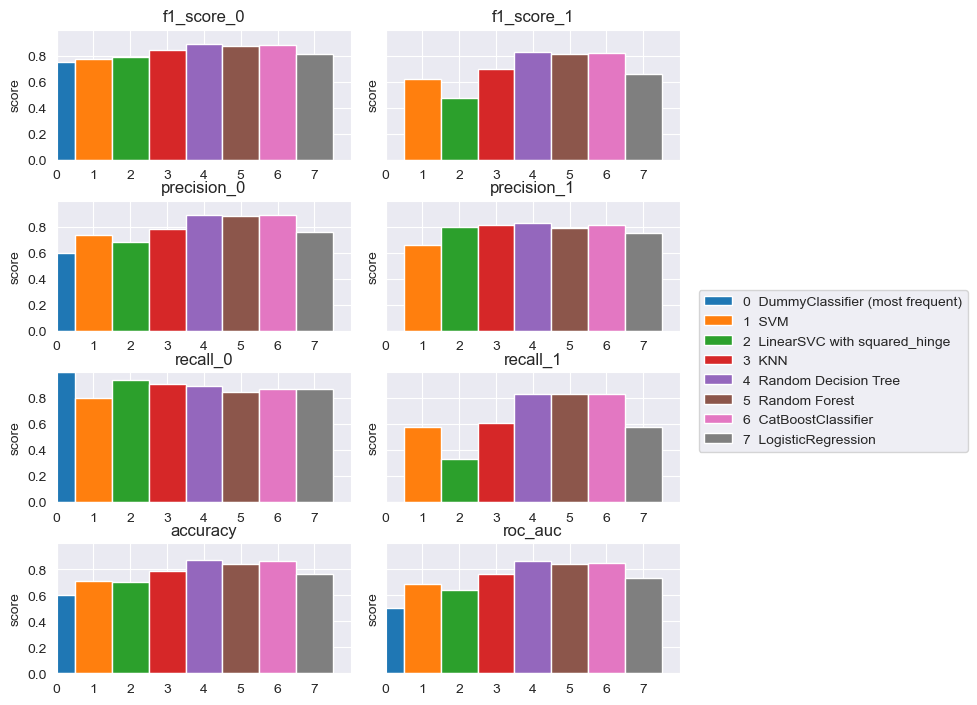

In [72]:
fig, (axes1, axes2, axes3, axes4) = plt.subplots(nrows=4, ncols=2, figsize=(7,7), sharey=True)
fig.tight_layout()
axes = list(axes1) + list(axes2) + list(axes3) + list(axes4)
i = 0
for item in model_results:
    clf = list(item.keys())[0]
    j = 0
    for score in item[clf]:
        value = item[clf][score]
        axes[j].set(
            xlim=(0,8), xticks=np.arange(0, 8),
            ylim=(0,1), yticks=np.arange(0, 1, 0.2),
            ylabel='score', title=score
        )
        axes[j].bar(x=i, height=value, width=1)
        j +=1
    i += 1

plt.legend([str(model_results.index(item)) + '  ' + str(list(item.keys())[0]) for item in model_results],
           bbox_to_anchor=(2, 3))
plt.show()

# Conclusion
- All models have better results than simple DummyClassifier
- SVC and LinearSVC have almost the same scores in accuracy, roc_auc and predicting dead people, but LinearSVC is worse than SVC in predicting survived people because it founds small number of all Survived (but do it more precisely).
- LogisticRegression is better than SVC, LinearSVC. Here I want to add that I had tested Logistic Regression model before SibSp, Parch, Name were divided into categories and model had gave me 0.87 accuracy. (I will return to this fact later)
- KNN algorithm has better score than SVC, LinearSVC, Logistic Regression have almost everywhere.
- All algorithms based on Decision Trees give us good scores in different type of tests, but Random Decision Tree has the best score.
- Making categories from numerical data helps to improve quality of model based on Decision Trees, but leads to decreasing of quality in Logistic Regression

# Answer Submission

In [116]:
test_data = pd.read_csv('data/titanic_classification_test.csv')
passenger_id = test_data['PassengerId'].copy()
test_data = test_data.drop(columns=['PassengerId', 'Ticket'])
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,NaN,S


In [101]:
test_data.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [118]:
from sklearn.preprocessing import OrdinalEncoder
from scipy import stats

test_data = test_data.drop(columns=['Cabin'])

test_data.loc[test_data['Age'].isnull(), 'Age'] = test_data.loc[~test_data['Age'].isnull(), 'Age'].median()

enc = OrdinalEncoder()
enc.fit(test_data[['Embarked']])
test_data['Embarked'] = enc.transform(test_data[['Embarked']])
test_data['Embarked'] = test_data['Embarked'].astype(int)

test_data['Pclass'] = test_data['Pclass'] - 1
test_data['Pclass'] = test_data['Pclass'].astype(int)


test_data['name_cat'] = test_data['Name'].apply(parse_name)
most_freq = ['Mr', 'Mrs', 'Miss', 'Master']
test_data['name_cat'] = test_data['name_cat'].apply(lambda x: x if x in most_freq else 'other')
test_data['name_cat'].unique()
enc = OrdinalEncoder()
enc.fit(test_data[['name_cat']])
test_data['name_cat'] = enc.transform(test_data[['name_cat']])
test_data.drop(columns=['Name'], inplace=True)
test_data['name_cat'] = test_data['name_cat'].astype(int)

test_data.drop(columns=['Sex'], inplace=True)

bins = [-0.1,0.5, 2, 4, 8]
labels = [0, 1, 2, 3]
test_data['SibSp'] = pd.cut(test_data['SibSp'], bins=bins, labels=labels).to_numpy()
test_data['SibSp'] = test_data['SibSp'].astype(int)


mode = stats.mode(test_data.loc[~test_data['Parch'].isnull(), 'Parch'].to_numpy().reshape(-1))[0][0]

test_data.loc[test_data['Parch'].isnull(), 'Parch'] = mode # Most common

bins = [-0.1,0.5, 2, 10]
labels = [0, 1, 2]
test_data['Parch'] = pd.cut(test_data['Parch'], bins=bins, labels=labels).to_numpy()
test_data['Parch'] = test_data['Parch'].astype(int)

test_data.loc[test_data['Fare'].isnull(), 'Fare'] = test_data.loc[~test_data['Fare'].isnull(), 'Fare'].mean()

In [119]:
test_data.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,name_cat
0,2,34.5,0,0,7.8292,1,2
1,2,47.0,1,0,7.0000,2,3
2,1,62.0,0,0,9.6875,1,2
3,2,27.0,0,0,8.6625,2,2
4,2,22.0,1,1,12.2875,2,3


In [120]:
from sklearn.tree import DecisionTreeClassifier
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=None)
clf.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [122]:
submission = pd.DataFrame({'PassengerId': passenger_id,
                        'Survived': clf.predict(test_data)})
submission.to_csv('submission.csv', index=False)